<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/Cacao_binary_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CACAO IMAGE BINARY DISEASE CLASSIFICATION**




By Gabriel Osei

## **Executive Summary**

This project developed a binary image classification model to distinguish between healthy and diseased cacao plants using deep learning techniques. The final model achieved 87% overall accuracy on the test dataset, with balanced performance across both classes.

## **Project Overview**
## Objective: Automate the detection of disease in cacao plants through image analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if False:
  import splitfolders

  splitfolders.ratio(
      "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized",
      output = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized_split",
      seed = 42,
      ratio = (.7, .15, .15),
  )
  pass

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

split_dir = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/reorganized_split"
checkpoint_path = "/content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras"

In [ ]:
config = {
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 50,
    "architecture": "MobileNetV2",
    "dropout": 0.5,
    "image_size": (224, 224),


    #data_augumentation
    "rotation_range": 20,
    "width_shift_range": 0.15,
    "height_shift_range": 0.15,
    "shear_range": 0.15,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "brightness_range": [0.8, 1.2],
    "fill_mode": "nearest",

    #other_important info
    "optimizer": "Adam",
    "loss":"binary_crossentropy",
    "metrics": ["accuracy"],
    "regularizer": l2(0.001),
    "early_stopping_patience": 53
}

This cell implements an optimized data loading pipeline to maximize GPU efficiency during model training. The key purpose is to eliminate bottlenecks where the GPU sits idle waiting for data to be prepared.
1. **Mixed precision training** reduces memory usage and speeds up computations by using 16-bit floats.
2. **GPU-based augmentation** ensures data transformations (flips, rotations, zooms) happen on the GPU rather than CPU, keeping processing collocated with training.
3. The **pipeline optimizations** through `.cache()` and `.prefetch()` are critical: caching stores preprocessed data in memory so it doesn't need to be reloaded and processed repeatedly each epoch, while prefetching overlaps data loading with model training—the next batch is prepared while the current batch trains, ensuring the GPU never waits. The `prepare_dataset` function systematically applies these optimizations, with augmentation strategically added only to training data to help the model learn robust features and generalize better to unseen images. This approach is essential for practical deep learning where training time and computational efficiency directly impact project feasibility.

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# REPLACE your entire ImageDataGenerator code with this:
import tensorflow as tf

# Create datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    image_size=config["image_size"],
    batch_size=config["batch_size"],
    label_mode="binary",
    shuffle=True
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    split_dir + "/val",
    image_size=config["image_size"],
    batch_size=config["batch_size"],
    label_mode="binary",
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    image_size=config["image_size"],
    batch_size=config["batch_size"],
    label_mode="binary",
    shuffle=False
)

# Augmentation layers (runs on GPU!)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(config["rotation_range"]/360),
    tf.keras.layers.RandomZoom(config["zoom_range"]),
])

# Apply preprocessing and optimization
def prepare_dataset(ds, augment=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

train_dataset = prepare_dataset(train_dataset, augment=True)
validation_dataset = prepare_dataset(validation_dataset, augment=False)
test_dataset = prepare_dataset(test_dataset, augment=False)

Found 3072 files belonging to 2 classes.
Found 657 files belonging to 2 classes.
Found 661 files belonging to 2 classes.


# **Image Visualization**

This cell provides a visual comparison of the dataset by selecting and displaying one sample image from each class (healthy and unhealthy cacao plants) side-by-side. It navigates to the test set directories, retrieves the first image from both the healthy and unhealthy folders, and uses matplotlib to create a clean side-by-side visualization with labeled titles and no axis clutter.

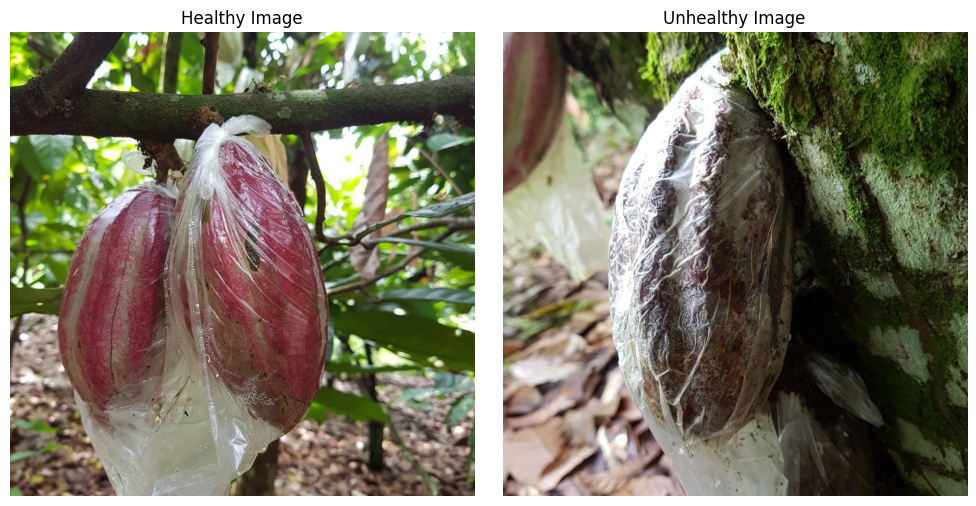

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to healthy and unhealthy images from the test set
healthy_image_path = os.path.join(split_dir, "test", "healthy", os.listdir(os.path.join(split_dir, "test", "healthy"))[0])
unhealthy_image_path = os.path.join(split_dir, "test", "unhealthy", os.listdir(os.path.join(split_dir, "test", "unhealthy"))[0])

# Load images
healthy_image = mpimg.imread(healthy_image_path)
unhealthy_image = mpimg.imread(unhealthy_image_path)

# Display images side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(healthy_image)
plt.title("Healthy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unhealthy_image)
plt.title("Unhealthy Image")
plt.axis('off')

plt.tight_layout()
plt.show()

This cell calculates class weights to address the dataset imbalance where healthy images outnumber unhealthy ones. It extracts all training labels from the dataset, flattens them, and uses compute_class_weight with the 'balanced' strategy to automatically assign higher weight to the minority class (unhealthy) and lower weight to the majority class (healthy). When applied during training via model.fit(), these weights modify the loss function so misclassifying an unhealthy sample incurs a larger penalty, forcing the model to focus more on detecting disease rather than being biased toward predicting "healthy" for everything due to class imbalance.

In [ ]:
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
y_train = y_train.flatten()  # Add this line to flatten the array

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.6564102564102564), 1: np.float64(2.098360655737705)}


# **Model Building (Transfer learning)**

This cell implements **transfer learning** using MobileNetV2, a pre-trained convolutional neural network that was already trained on millions of ImageNet images to recognize general visual features. Instead of training a model from scratch (which would require massive datasets and computational resources), this approach leverages MobileNetV2's learned feature extraction capabilities and adapts it for cacao disease classification. The base model's layers are frozen (`trainable=False`) to preserve the powerful pre-trained feature detectors, preventing them from being modified during training. On top of the frozen base, custom classification layers are added: **GlobalAveragePooling2D** condenses the feature maps into a single vector, **Dropout** helps prevent overfitting by randomly deactivating neurons during training, and a **Dense layer with sigmoid activation** produces the final binary prediction (healthy vs unhealthy). The model is compiled with the Adam optimizer and configured loss/metrics for binary classification. Two critical callbacks are implemented: **ModelCheckpoint** automatically saves the best-performing model during training (monitoring validation accuracy), and **EarlyStopping** halts training if validation accuracy stops improving for a specified number of epochs, preventing wasted computation and overfitting. This architecture is efficient, requiring less training time and data while achieving strong performance by building on established computer vision knowledge.

In [ ]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=config["image_size"] + (3,)
)

base_model.trainable = False #freezing the layers to avoid data from retraining our model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(config["dropout"])(x)

outputs = Dense(
    1,
    activation="sigmoid",
    kernel_regularizer=config["regularizer"]
)(x)

final_model = Model(
    inputs=base_model.input,
    outputs=outputs
)

final_model.compile(
    optimizer=Adam(learning_rate=config["learning_rate"]),
    loss=config["loss"],
    metrics=config["metrics"]
)

# Making sure model saves at checkpoints

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=config["early_stopping_patience"],
    restore_best_weights=True,
    mode="max"
)

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = final_model.fit(
    train_dataset,
    epochs = config["epochs"],
    class_weight = class_weight_dict,
    validation_data = validation_dataset,
    callbacks = [model_checkpoint, early_stopping]
)

Epoch 1/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5420 - loss: 0.7963
Epoch 1: val_accuracy improved from -inf to 0.78691, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 739ms/step - accuracy: 0.5460 - loss: 0.7909 - val_accuracy: 0.7869 - val_loss: 0.4519
Epoch 2/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7646 - loss: 0.5303
Epoch 2: val_accuracy improved from 0.78691 to 0.82801, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7650 - loss: 0.5290 - val_accuracy: 0.8280 - val_loss: 0.3861
Epoch 3/50
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7981 - loss: 0.4651
Epoch 3: val_accuracy improved from 0.82801 to 0.83562, saving model to /content/drive/MyDrive/DS2_nov 4/checkpoint/best_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7982 - loss: 0.4646 - val_accuracy: 0.8356 - val_loss: 0.3783

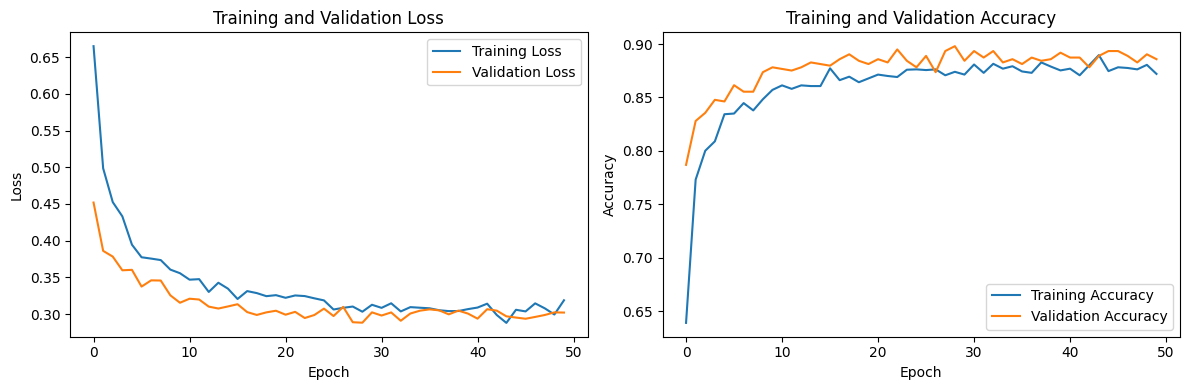

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Evaluating model on test images....")
test_loss, test_accuracy = final_model.evaluate(test_dataset)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Evaluating model on test images....
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8856 - loss: 0.2973
Test loss: 0.3263
Test accuracy: 0.8669


This output shows the final model evaluation on the test set—data the model has never seen during training or validation. The key results are test accuracy of 86.69% and test loss of 0.3263, which closely match the validation performance observed during training (~87-88% accuracy). This consistency between validation and test metrics confirms the model generalizes well and isn't overfitting it performs similarly on completely unseen data as it did on validation data. The test accuracy of 86.69% represents the model's real-world performance capability, meaning it correctly classifies approximately 87 out of every 100 cacao plant images as either healthy or diseased. This evaluation provides the definitive measure of model quality and demonstrates the model is ready for practical application in cacao disease detection.

Generating predictions on test data.....
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Confusion Matrix:
[[458  45]
 [ 43 115]]


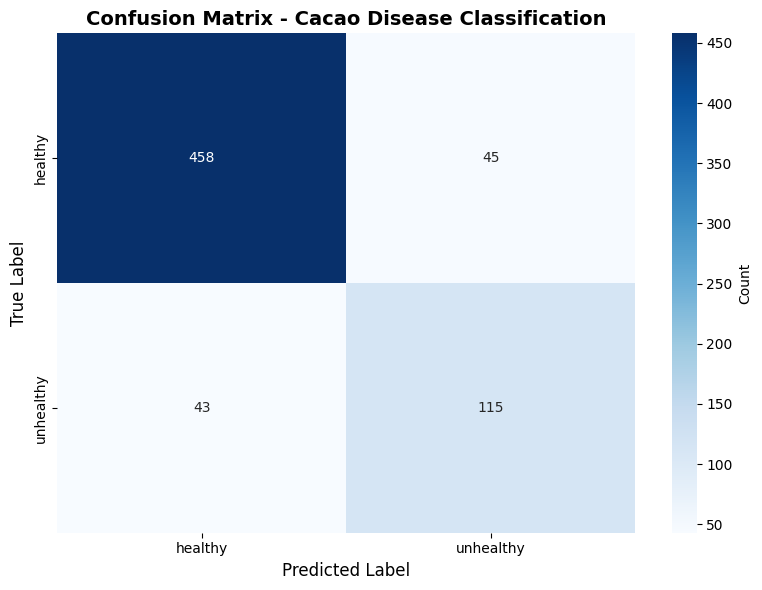


Classification Report:
              precision    recall  f1-score   support

     healthy       0.91      0.91      0.91       503
   unhealthy       0.72      0.73      0.72       158

    accuracy                           0.87       661
   macro avg       0.82      0.82      0.82       661
weighted avg       0.87      0.87      0.87       661



In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating predictions on test data.....")
y_pred_prob = final_model.predict(test_dataset)
y_pred = np.round(y_pred_prob)

# Extract true labels from the dataset
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
class_names = sorted(os.listdir(split_dir + "/test"))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Cacao Disease Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# **Conclusion**
The cacao disease classification model demonstrates strong performance with 87% accuracy and balanced precision-recall metrics across both healthy and diseased classes. The 73% disease detection rate, while not perfect, provides a valuable automated screening capability that significantly outperforms random classification.

While there is room for improvement particularly in reducing the 27% false negative rate for diseased plants the current model provides a solid foundation for automated cacao health monitoring. With continued data collection and threshold optimization, this system could become a valuable tool in agricultural disease management workflows.